In [1]:
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from sympy import Symbol, Derivative
from scipy import interpolate
from scipy.interpolate import griddata

from time import time
import gzip
import shutil, os, sys
import pandas as pd
from os.path import dirname
import json
from commands import getoutput as cmd
import seaborn as sns
from scipy import ndimage
sns.set(font_scale = 1.3)

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline


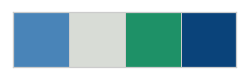

In [2]:
parent_dir = (dirname(os.getcwd()))
current_dir = (os.getcwd())
sys.path.append(parent_dir )

    
sys.path.append("/".join([parent_dir, 'model']) )
mymods = ['plot_functions', 'ipynb_help']
for mymod in mymods:
    if mymod in sys.modules: 
        del sys.modules[mymod]

import cmocean
from plot_functions import *
from ipynb_help import *

base_dir = current_dir

In [3]:

fname = '{0}/all_params.json'.format(current_dir)
all_params = json.load(open(fname))


In [4]:
# factorial combinations of these variables
for key in all_params['batch_dict']:
    print key,  all_params['batch_dict'][key]
for key in all_params['sim_dict']:
    print key,  all_params['sim_dict'][key]    

Ks [3.0]
p [1, 21, 2]
grad_fV [0.1, 0.3]
nrow [10, 101, 10]


In [5]:
sims, core= load_core(base_dir)

In [6]:
def update_sims(sims):
    for key in sims.keys():
        sim = sims[key]
        # mean infiltration depth in vegetated areas
        sims[key]['inflDveg'] = sim.zinflc[sim.isvegc== 1].mean()    
        # infiltration fraction
        sims[key]['infl_frac'] = sim.zinflc.mean()/(sim.tr*sim.p/60.)
        sims[key]['inflD'] = sim.zinflc.mean()        
        sims[key]['runtime_hr'] = sim.runtime/3600.
        sims[key]['i_tr'] = int(sim.tr*60/sim.dt_p)
        sims[key]['fV'] = np.mean(sim.isvegc)

        sims[key]['qmax']= np.max(sim['hydro']*3.6e3)
        sims[key]['pQ']= sim.p- sim.Ks*sim.fV
        from scipy.signal import savgol_filter

        yhat = savgol_filter(sim.hydro, 301, 3) # window size 51, polynomial order 3
        sims[key]['time_p1'] = int(sim.t_h[200:-1][np.diff(yhat[200:])*sim.Ly/100*3600**2 <0.1][0])    
        sims[key]['time_p2'] = int(sim.t_h[200:-1][np.diff(yhat[200:])*sim.Ly/100*3600**2 <0.2][0])
        sims[key]['time_p3'] = int(sim.t_h[200:-1][np.diff(yhat[200:])*sim.Ly/100*3600**2 <0.3][0]        )
    return sims

sims = update_sims(sims)
keys = sims.keys()
core = pd.DataFrame(sims).T

In [7]:
cm 

<module 'matplotlib.cm' from '/usr/local/lib/python2.7/site-packages/matplotlib/cm.pyc'>

Text(0.5,1,'Hydrographs')

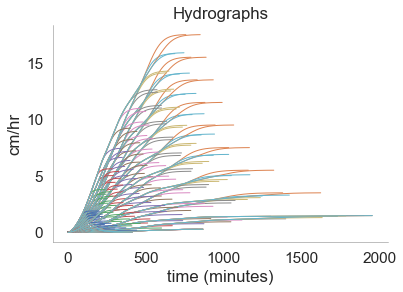

In [8]:
plt.figure()
for key in core[np.all([core.sigma >0, core.fV >0], axis =0)].index:

        sim = sims[key]
        dum=np.diff(sim.hydro[1000:])*3600**2
        plt.plot(sim['t_h'][:sim.time_p2], sim['hydro'][:sim.time_p2]*sim.Ly/100*3.6e3, label =key )

plt.xlabel('time (minutes)')
plt.ylabel('cm/hr')
plt.title('Hydrographs')
# plt.legend()
# plt.ylim(0, 1)

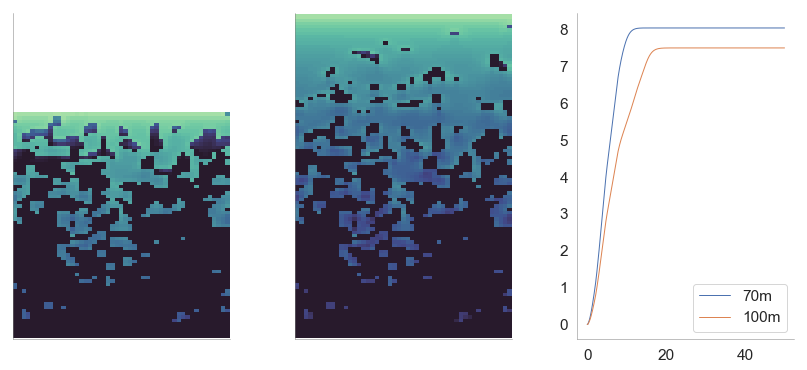

In [9]:
### Comparing hillslope sizes
fig = plt.figure(figsize= (14,6))
plt.subplots_adjust(wspace = 0.3)

ax1 = plt.subplot(131)
sim7 = core.loc['Ks-3.0,p-9/grad_fV-0.3,nrow-70/']
colormap(sim7,sim7.vmax, ax=ax1, bounds = np.arange(0,8,.1),colorbar=False)
ax1.set_ylim(0,100)
ax1= plt.subplot(132)
sim10 =core.loc['Ks-3.0,p-9/grad_fV-0.3,nrow-100/']
colormap(sim10,sim10.vmax, ax=ax1, bounds = np.arange(0,8,.1),colorbar=False)
ax1.set_ylim(0,100)

ax1= plt.subplot(133)
plt.plot(sim7['t_h']/60, sim7['hydro']*3.6e3, label = "70m" )
plt.plot(sim10['t_h']/60, sim10['hydro']*3.6e3, label = "100m" )

plt.legend()

(0, 100)

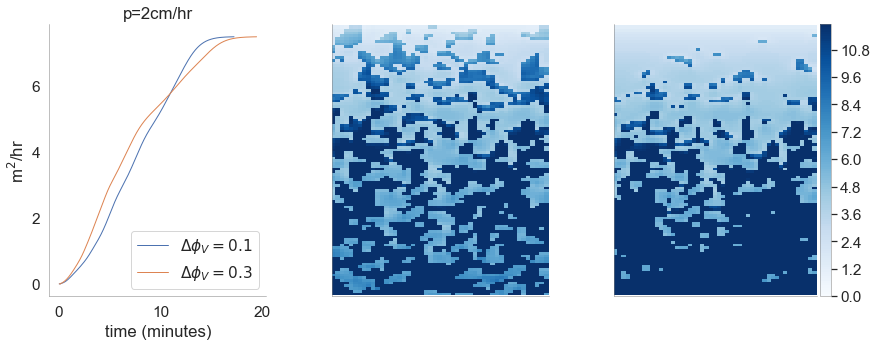

In [10]:
## comparing vegetation fraction gradients
fig = plt.figure(figsize= (14,5))
plt.subplots_adjust(wspace = 0.3)
#plt.rcParams.update({'font.size': 30})

ax1 = plt.subplot(131)

sim_p1 = core.loc['Ks-3.0,p-9/grad_fV-0.1,nrow-100/']
sim_p3 =core.loc['Ks-3.0,p-9/grad_fV-0.3,nrow-100/']

tf = int(sim_p1.time_p2)
ax1.plot(sim_p1['t_h'][:tf]/60, sim_p1['hydro'][:tf]*3.6e3*sim_p1.Ly/100, label  =r"$\Delta \phi_V=0.1$")
tf = int(sim_p3.time_p2)
ax1.plot(sim_p3['t_h'][:tf]/60, sim_p3['hydro'][:tf]*3.6e3*sim_p3.Ly/100, label  =r"$\Delta \phi_V=0.3$")
ax1.legend()
plt.xlabel('time (minutes)')
plt.ylabel('m$^2$/hr')
plt.title('p=2cm/hr')
# 

ax1 = plt.subplot(132)

colormap(sim_p1,sim_p1.vmax, cmap = "Blues", ax=ax1, bounds = np.arange(0,12, 0.1),colorbar=False)
ax1.set_ylim(0,100)
ax1= plt.subplot(133)

cb=colormap(sim_p3,sim_p3.vmax, cmap = "Blues", ax=ax1, bounds = np.arange(0,12, 0.1),colorbar=True)
ax1.set_ylim(0,100)


Text(0.5,0,'$p$')

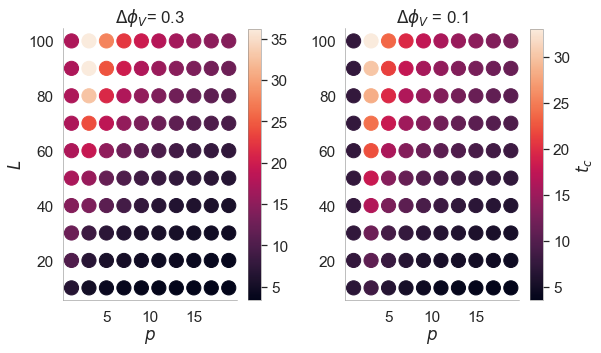

In [11]:
## gridded view
## comparing vegetation fraction gradients
fig = plt.figure(figsize= (14,5))
plt.subplots_adjust(wspace = 0.3)

ax1 = plt.subplot(131)

d = core[core.grad_fV==0.3]
plt.scatter(d.p, d.Ly, c= d.time_p1/60, s= 200)
plt.colorbar()
plt.title("$\Delta \phi_V $= 0.3")
plt.xlabel("$p$")
plt.ylabel("$L$")

ax1 = plt.subplot(132)

d = core[core.grad_fV==0.1]
plt.scatter(d.p, d.Ly, c= d.time_p1/60, s= 200)
plt.colorbar(label ="$t_c$")
plt.title("$\Delta \phi_V$ = 0.1")
plt.xlabel("$p$")

In [12]:
core['A']= core['Ly']*core['Lx']
core['A_imp']= core['Ly']*core['Lx']*(1-core['fV'])

Text(0.5,0,'$p$')

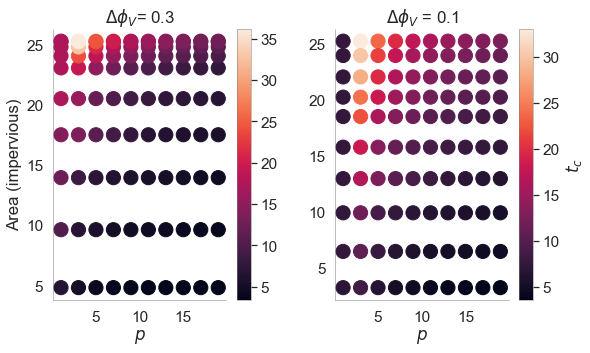

In [13]:
## gridded view
## comparing vegetation fraction gradients
fig = plt.figure(figsize= (14,5))
plt.subplots_adjust(wspace = 0.3)

ax1 = plt.subplot(131)

d = core[core.grad_fV==0.3]
plt.scatter(d.p, d.A_imp/100, c= d.time_p1/60, s= 200)
plt.colorbar()
plt.title("$\Delta \phi_V $= 0.3")
plt.xlabel("$p$")
plt.ylabel("Area (impervious)")

ax1 = plt.subplot(132)

d = core[core.grad_fV==0.1]
plt.scatter(d.p, d.A_imp/100, c= d.time_p1/60, s= 200)
plt.colorbar(label ="$t_c$")
plt.title("$\Delta \phi_V$ = 0.1")
plt.xlabel("$p$")

In [14]:
def I(D): # IDF function
    return k1*(D**b1+k2)**(-b2)


# calculate curve fit
def func(x, a, b, c,d):
    #return a+b/(x**3+c) #1
    #return a*x/(b+x**2)**(0.5)+c #3
    return a*np.arctan(b*x+d)+c  #2
    #return (np.exp(a*x)/(c+np.exp(b*x)))+d


def funcder(x,a,b,c,d):
    #return (-3.*b*x**2)/(x**3+c)**2 #1
    return a*b/((b*x+d)**2+1)  #2
    #return a*(1./(b+x**2)**0.5-x**2/(b+x**2)**1.5) #3

In [17]:
## Rational Method optimization based on a user-defined IFD curve
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'font.size': 20})

d = core[core.grad_fV==0.3]
         
k1 = 70 # constant for IDF function of the form I=k1(D^b1+k2)^(-b2)
k2 = 0
b1 = 0.3
b2 = 1.0 # power for IDF function
bb=-1*b1


timelist = []
arealist = []
intensitylist = []
timelistupper = []
arealistupper = []
intensitylistupper = []
timelistlower = []
arealistlower = []
intensitylistlower = []
timelist1 = []
arealist1 = []
intensitylist1 = []

tolerance = 4 # distance from IFD curve for points to use in interpolation
size = 40
    
# find points to use for interpolation
for i in range(len(d.p)):
    if abs(d.p[i]-(d.time_p1[i])**bb*k1)<tolerance:
        timelist = timelist+[float(d.time_p3[i])]
        arealist = arealist+[float(d.A_imp[i]/100)]
        intensitylist = intensitylist+[float(d.p[i])]

# sort together time, area, and intensity values indentified for interpolation
sorttime = [float(timelist[0])]
sortarea = [arealist[0]]
sortintensity = [intensitylist[0]]
for i in range(len(timelist)-1):
    for j in range(len(sorttime)):
        if sorttime[j]>timelist[i]:
            sorttime.insert(j,timelist[i])
            sortarea.insert(j,arealist[i])
            sortintensity.insert(j,intensitylist[i])
        elif j==len(sorttime)-1:
            sorttime = sorttime+[timelist[i]]
            sortarea = sortarea+[arealist[i]]
            sortintensity = sortintensity+[intensitylist[i]]


mm=250 # minimum time for optimization
mama=1200 # maximum time for optimization
pts=1000 # resolution of numerical optimization

# conduct numerical optimization
tnew = np.linspace(mm,mama,pts)
inew = [k1*tn**bb for tn in tnew]
anew = []
#interpolate contributing area data
for i in range(len(tnew)):
    anew = anew+[griddata((sorttime,sortintensity),sortarea,(tnew[i],inew[i]),'linear')]

# remove infinite values from contributing area data
for i in range(len(tnew)):
    if anew[i]>1000000000000000 or not (anew[i]>0):
        anew=anew[:i]+anew[i+1:]
        tnew=tnew[:i]+tnew[i+1:]
        inew=inew[:i]+inew[i+1:]

# fit a curve to the interpolated area values
popt, pcov = curve_fit(func, tnew, anew)
tvals = np.linspace(200,1500,100)

print 'Amax = ', max(anew) # print impervious area of hillslope

# find D_crit
tcind = 0
for i in range(len(anew)):
    if max(anew)-anew[i]<0.01*max(anew) and tcind==0:
        tcind = i

# find maximum flow values
maxval = max([anew[i]*I(tnew[i]) for i in range( len(tnew))])
ind = 0
for i in range(len(tnew)):
    if anew[i]*I(tnew[i])==maxval:
        ind = i
print 'Q_max = ',maxval, ', D_crit = ',tnew[ind]


print'done'

Amax =  25.270000000000003
Q_max =  236.55599656839746 , t_c =  601.8518518518518
done


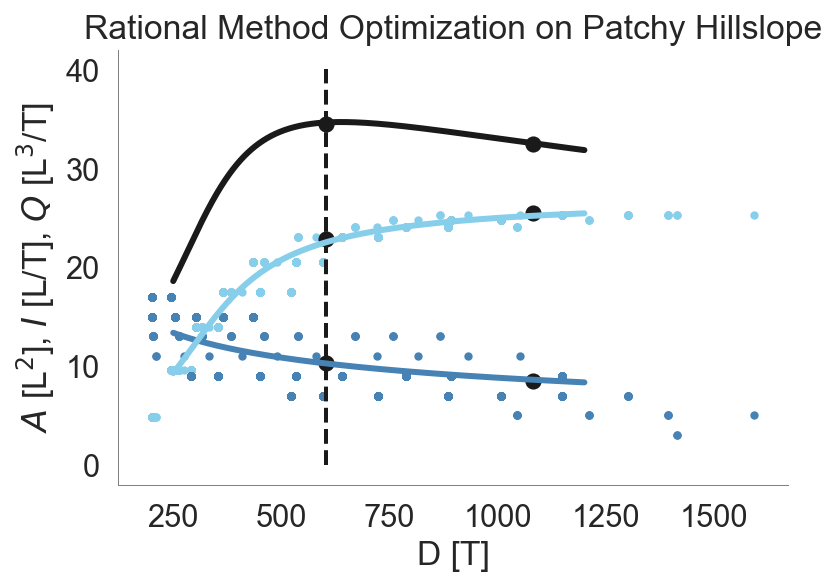

In [20]:
#plot optimization and points used for interpolation

# plot contributing area values used for interpolation
plt.scatter(sorttime,sortarea,c='skyblue',marker='.',s=size)

# plot vertical line at D_crit
plt.plot([tnew[ind],tnew[ind]],[0,40],linestyle='--',c='k',linewidth = 2)

# plot IFD curve
ttt = np.linspace(mm,mama,pts)
plt.plot(ttt,[k1*tt**bb for tt in ttt],linewidth=3,c='steelblue')


# plot intensity data used for interpolation
plt.scatter(sorttime,sortintensity,c='steelblue',marker = '.',s=size)
        


# plot Q \propto AI
plt.plot(tnew,[0.15*func(tnew[i],*popt)*I(tnew[i]) for i in range( len(tnew))],linewidth = 3,c='k')


# plot fitted contributing area function
plt.plot(tnew, [func(tnew[i],*popt) for i in range(len(tnew))], 'r-', linewidth = 3,c='skyblue',label='fit: a=%5.3f, b=%5.3f, c=%5.3f ,d=%5.3f'% tuple(popt))

# mark t_c and D_crit on each curve
plt.scatter([tnew[ind]],[10.3],c='k',s=50)
plt.scatter([tnew[ind]],[22.8],c='k',s=50)
plt.scatter([tnew[ind]],[34.5],c='k',s=50)
plt.scatter([tnew[tcind]],[8.5],c='k',s=50)
plt.scatter([tnew[tcind]],[25.5],c='k',s=50)
plt.scatter([tnew[tcind]],[32.5],c='k',s=50)


plt.xlabel('D [T]')
plt.ylabel('$A$ [L$^2$], $I$ [L/T], $Q$ [L$^3$/T]')
plt.title('Rational Method Optimization on Patchy Hillslope')

plt.show()

In [21]:
core[['p','grad_fV', 'Ly','A','A_imp','time_p1','time_p2','time_p3', ]].to_csv("results.csv")

Text(0,0.5,'m$^2$/hr')

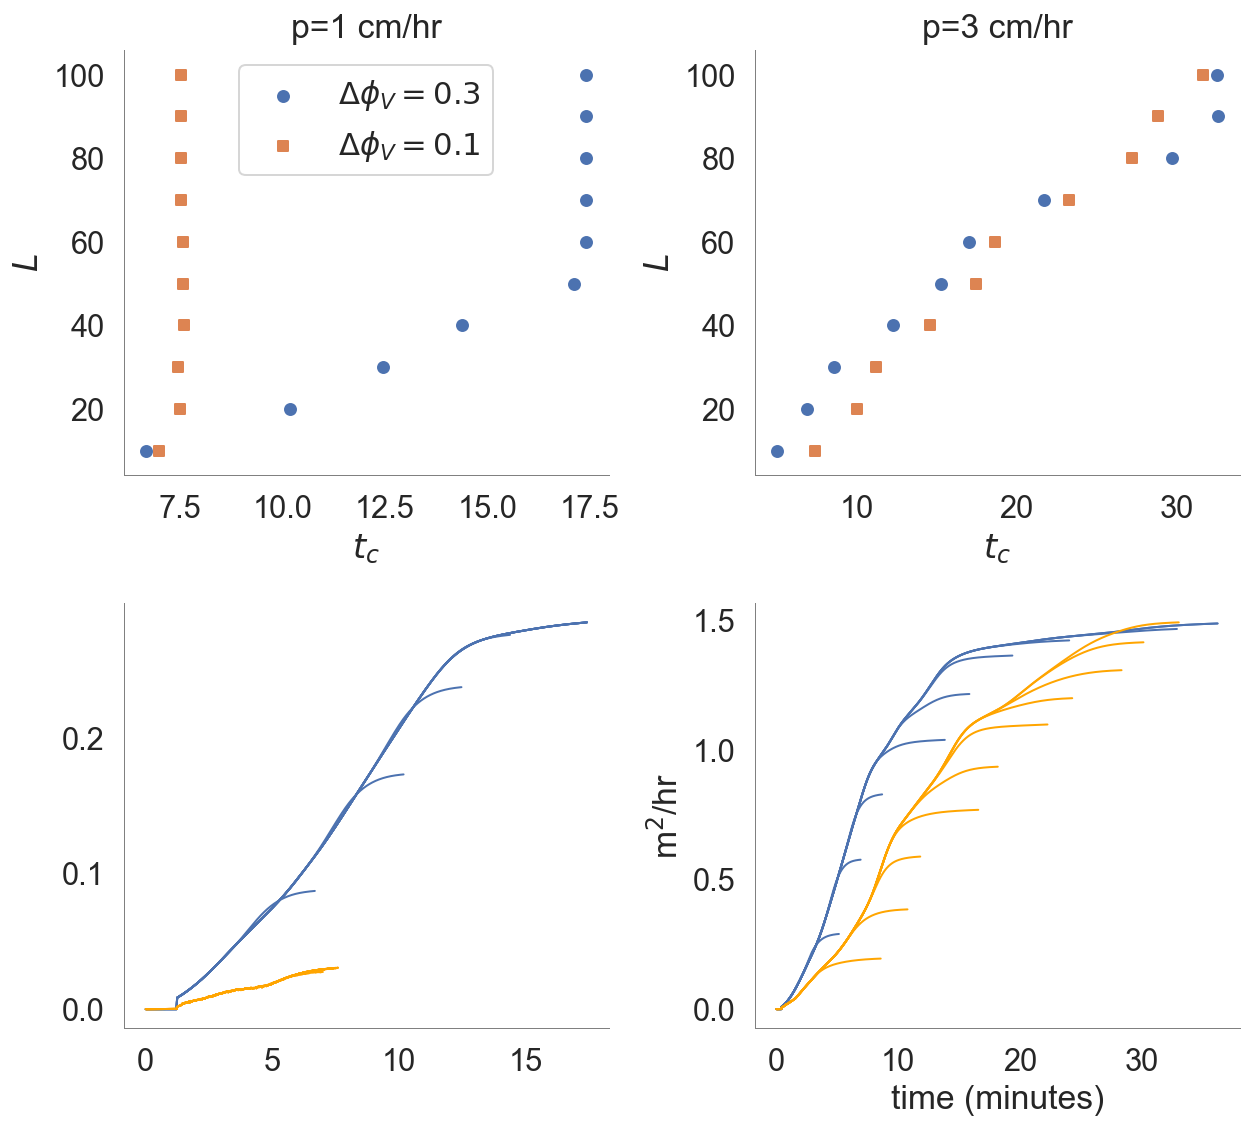

In [22]:
fig = plt.figure(figsize= (10,9))
plt.subplots_adjust(wspace = 0.3)

plt.subplots_adjust(hspace = 0.3)

ax1 = plt.subplot(221)

core_l = core[(core.p==1)&(core.grad_fV ==0.3)]
core_lp1 = core[(core.p==1)&(core.grad_fV ==0.1)]

core_h =  core[(core.p==3)&(core.grad_fV ==0.3)]
core_hp1 =  core[(core.p==3)&(core.grad_fV ==0.1)]


plt.scatter(core_l.time_p1/60.,core_l.Ly,  s=30, label =r"$\Delta \phi_V=0.3$")
plt.scatter( core_lp1.time_p1/60.,core_lp1.Ly, marker='s', s=30,label =r"$\Delta \phi_V=0.1$")
plt.xlabel("$t_c$")

plt.ylabel("$L$")
ax1.legend()
plt.title('p=1 cm/hr')
ax1 = plt.subplot(222)


plt.scatter(core_h.time_p2/60.,core_h.Ly,   s=30,label =r"$\Delta \phi_V=0.3$")
plt.scatter(core_hp1.time_p2/60.,core_hp1.Ly, marker='s', s=30,label =r"$\Delta \phi_V=0.1$")

plt.xlabel("$t_c$")
plt.ylabel("$L$")
plt.title('p=3 cm/hr')

ax1 = plt.subplot(223)
for key in core_l.index:
        sim = sims[key]        
        ax1.plot(sim['t_h'][:sim.time_p1]/60, sim['hydro'][:sim.time_p1]*3.6e3*sim.Ly/100, c='b')
for key in core_lp1.index:
        sim = sims[key]    
        ax1.plot(sim['t_h'][:sim.time_p1]/60, sim['hydro'][:sim.time_p1]*3.6e3*sim.Ly/100, c='orange')            

ax1 = plt.subplot(224)
for key in core_h.index:
        sim = sims[key]        
        ax1.plot(sim['t_h'][:sim.time_p1]/60, sim['hydro'][:sim.time_p1]*3.6e3*sim.Ly/100, c='b')
for key in core_hp1.index:
        sim = sims[key]    
        ax1.plot(sim['t_h'][:sim.time_p1]/60, sim['hydro'][:sim.time_p1]*3.6e3*sim.Ly/100, c='orange')            

        
plt.xlabel('time (minutes)')
plt.ylabel('m$^2$/hr')

2


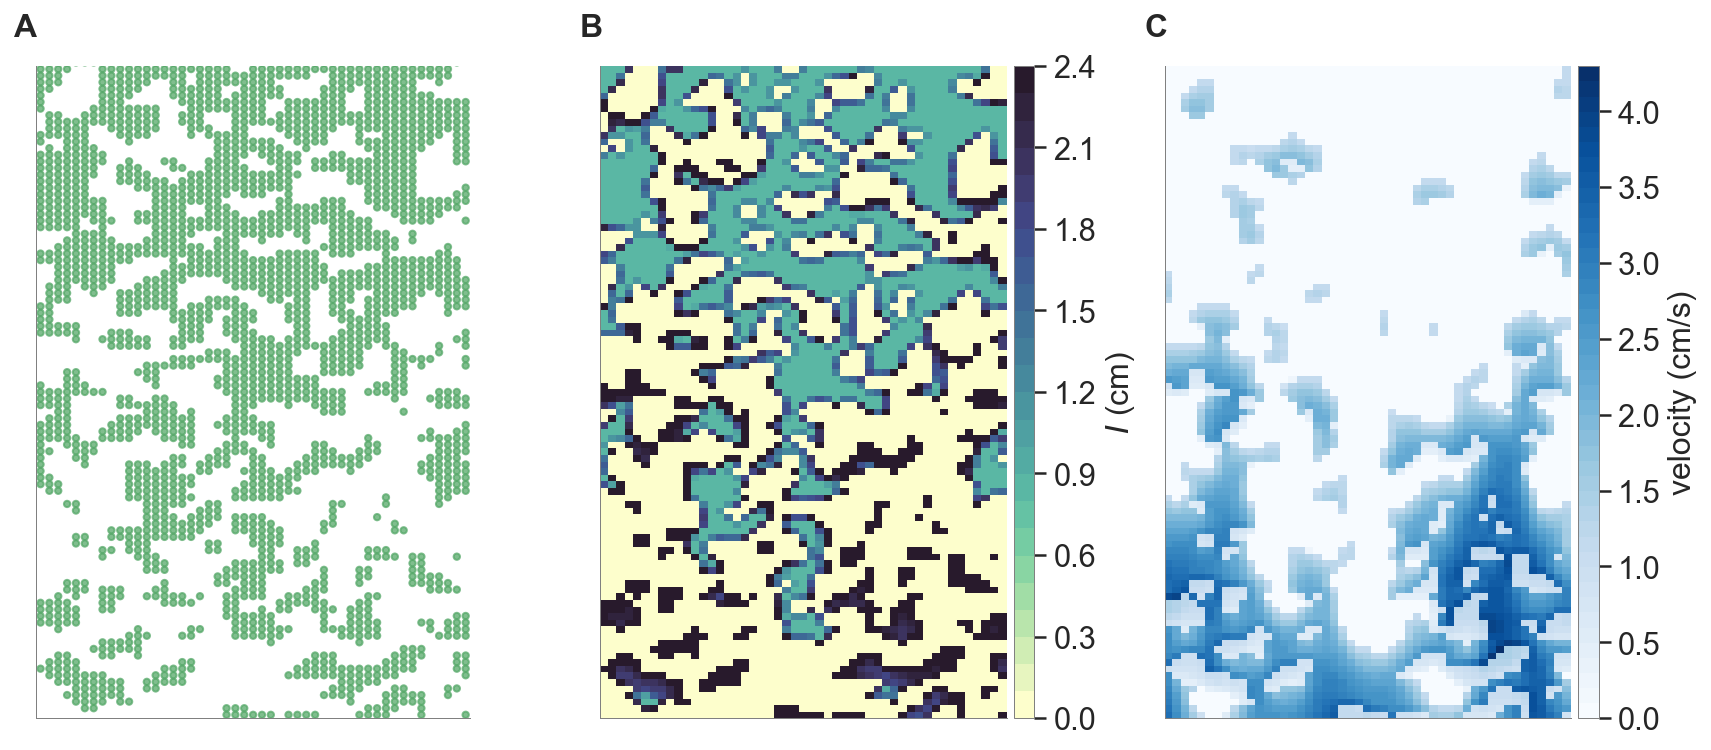

In [23]:
key =core.iloc[1].name
sim  = sims[key]
print sim.seed
fig = plt.figure(figsize= (14,6))
plt.subplots_adjust(wspace = 0.3)

for i, label in enumerate(('A', 'B', 'C')):
    ax = plt.subplot(1,3,i+1)
    ax.text(-0.05, 1.08, label, transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top')


ax1 = plt.subplot(131)
# color_topo(sim.zc, ax = ax1, dx = sim.dx)
vegplot = veg_points(sim.isvegc, dx  = sim.dx, ax = ax1)
# plt.scatter(10,10,c='r')

ax1 = plt.subplot(132)
zinflplot = colormap(sim,sim['zinflc'], ax = ax1, clabel= '$I$ (cm)', colorbar = True , cround = 1)

ax = plt.subplot(133)
zinflplot = colormap(sim,sim['vmax'], ax = ax, clabel= 'velocity (cm/s)' ,colorbar = True, cmap = "Blues",
                     cround = 1,     veg_scale=False)


0 AxesSubplot(0.125,0.125;0.168478x0.755)
1 AxesSubplot(0.327174,0.125;0.168478x0.755)
2 AxesSubplot(0.529348,0.125;0.168478x0.755)
3 AxesSubplot(0.731522,0.125;0.168478x0.755)


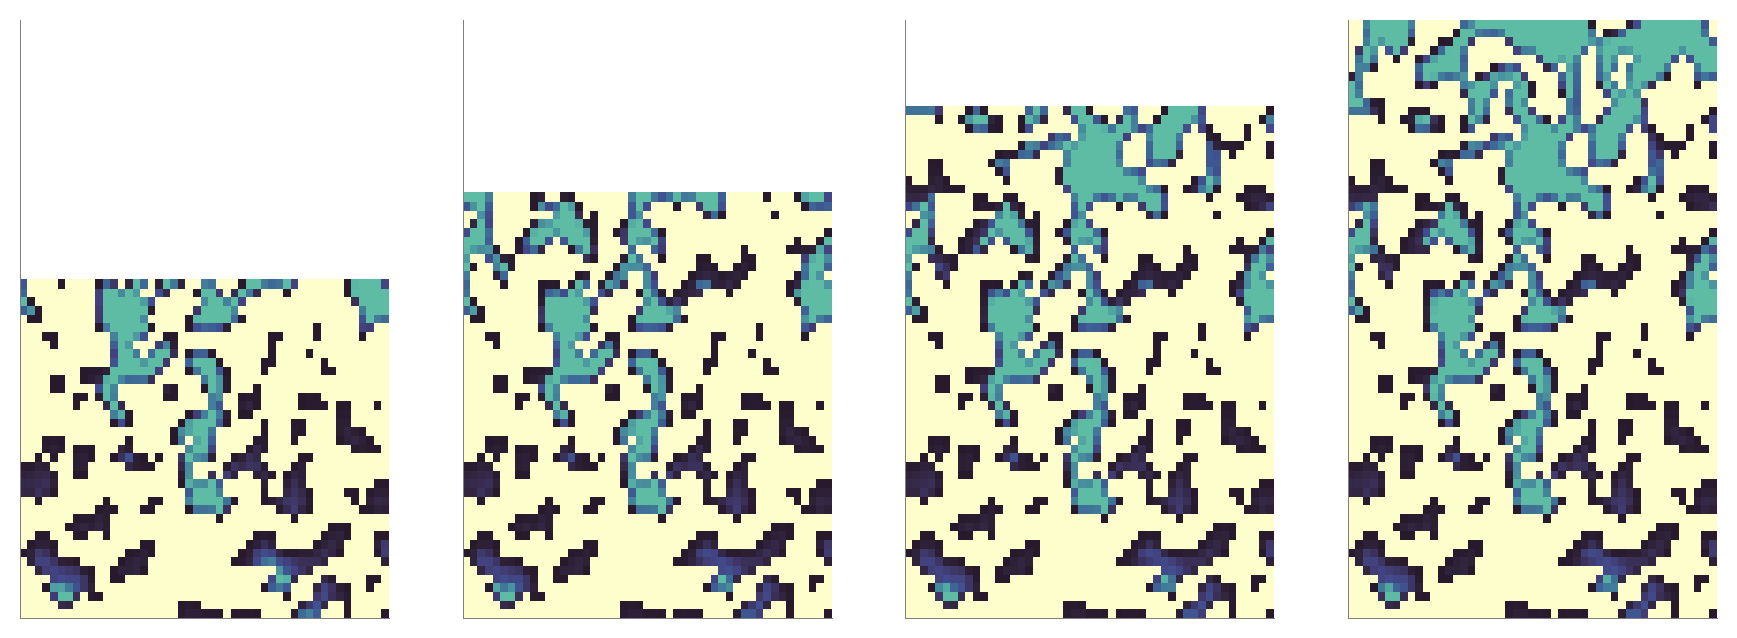

In [24]:
fig, axes = plt.subplots(1,4, figsize = (15.2, 5.5), sharey = True,sharex = True)
i =0
for i,ax in enumerate(axes):
    print i,ax
    sim = core.iloc[i+4]
    colormap(sim, sim['zinflc'],ax=ax, colorbar = False)

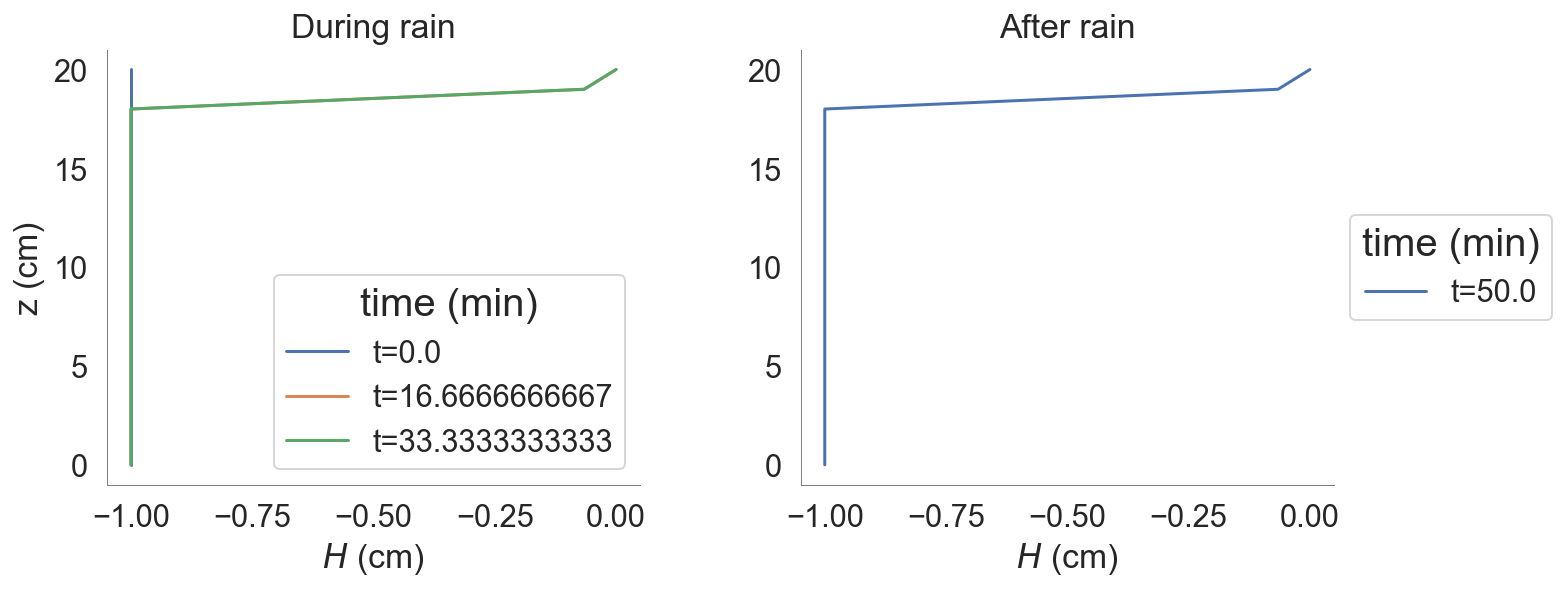

In [25]:
sim = sims[key]

z = np.arange(0, sim.zmax+sim.dz, sim.dz)

fig = plt.figure(1, figsize = (11,4)); 
ax1 = plt.subplot(121)
plt.subplots_adjust(wspace = .3)
plt.xlabel('$H$ (cm)')
plt.ylabel('z (cm)')
plt.title('During rain')

inds = np.where(sim.t_p < sim.t_rain)[0]
freq = len(sim.t_p[inds])/3
for i in inds[::freq]:
    plt.plot(sim.bareH[i],z, label = 't={0}'.format(sim.t_p[i]/60), lw = 1.5)
ax1.legend(loc = 'best', title = 'time (min)')

ax2 = plt.subplot(122)
plt.xlabel('Soil moisture $cm^3/cm^3$')
plt.xlabel('$H$ (cm)')
plt.title('After rain')
inds = np.where(sim.t_p >= sim.t_rain)[0]
freq = len(sim.t_p[inds])/3
freq = 1
for i in inds[::freq]:
    plt.plot(sim.bareH[i],z, label = 't={0}'.format(sim.t_p[i]/60), lw = 1.5)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'time (min)')
# plt.suptitle(key, fontsize = 14)

[None, None]

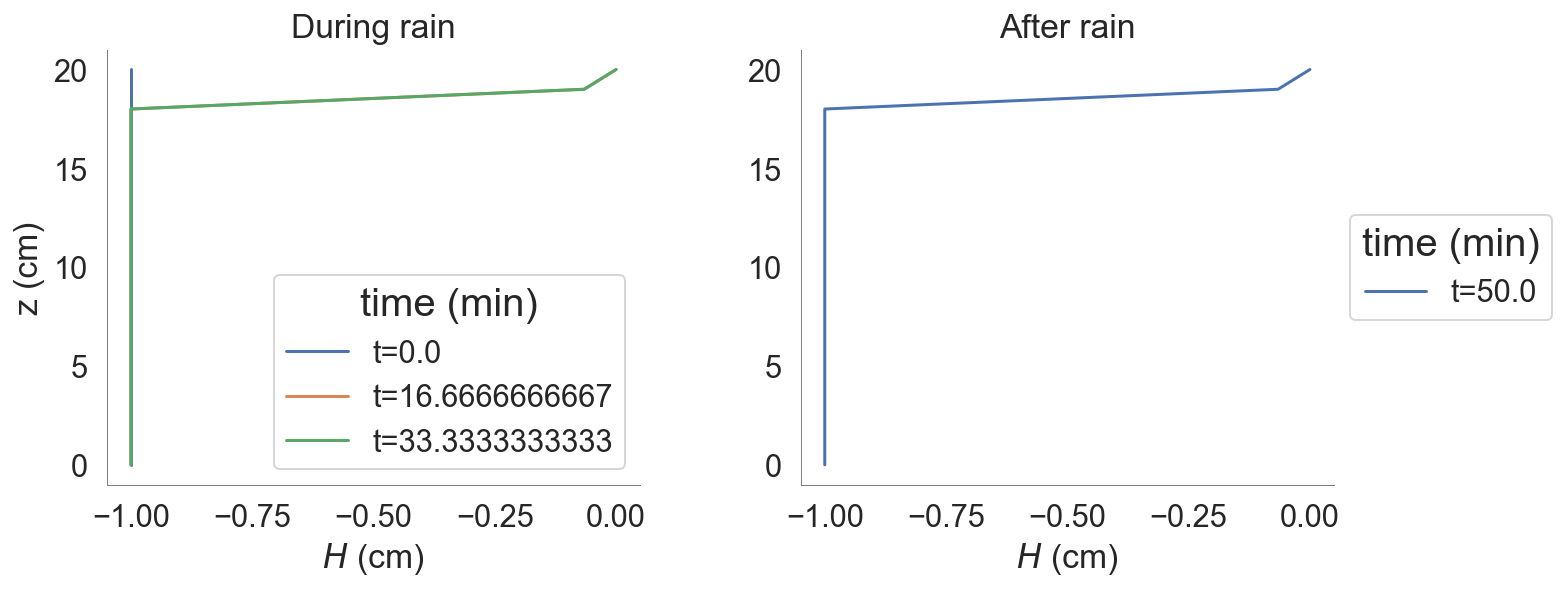

In [26]:
sim = sims[key]

z = np.arange(0, sim.zmax+sim.dz, sim.dz)

fig = plt.figure(1, figsize = (11,4)); 
ax1 = plt.subplot(121)
plt.subplots_adjust(wspace = .3)
plt.xlabel('$H$ (cm)')
plt.ylabel('z (cm)')
plt.title('During rain')

inds = np.where(sim.t_p < sim.t_rain)[0]
freq = len(sim.t_p[inds])/3
for i in inds[::freq]:
    plt.plot(sim.vegH[i],z, label = 't={0}'.format(sim.t_p[i]/60), lw = 1.5)
legend = ax1.legend(loc = 'best', title = 'time (min)')
plt.setp(legend.get_title(),fontsize="medium")

ax2 = plt.subplot(122)
plt.xlabel('Soil moisture $cm^3/cm^3$')
plt.xlabel('$H$ (cm)')
plt.title('After rain')
inds = np.where(sim.t_p >= sim.t_rain)[0]
freq = len(sim.t_p[inds])/3
freq = 1
for i in inds[::freq]:
    plt.plot(sim.vegH[i],z, label = 't={0}'.format(sim.t_p[i]/60), lw = 1.5)
legend = ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'time (min)')
plt.setp(legend.get_title(),fontsize="medium")


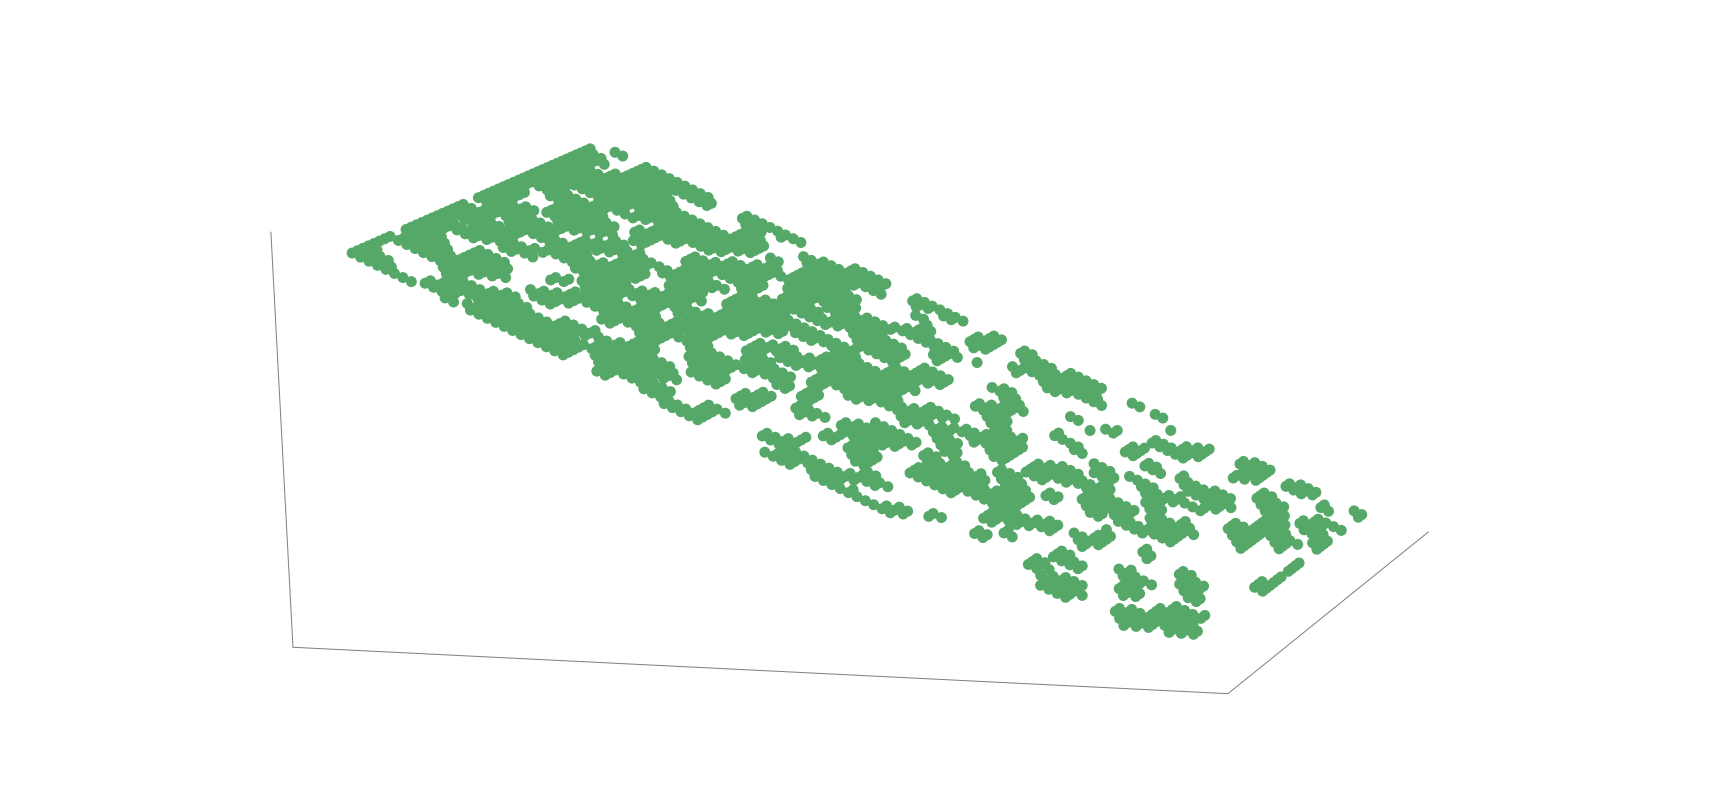

In [27]:
### Here is a 3D plot, for illustration only

fig = plt.figure( figsize = (15, 7))
ax = fig.add_subplot(111, projection='3d')

# Get rid of colored axes planes
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.set_xticks([], []);
ax.set_zticks([], []);
ax.set_yticks([], []);
# plt.axis('off')
ax.grid(False)

#Plot the surface with face colors taken from the array we made.
norm = plt.Normalize()
colors = cm.Greens(norm(sim.isvegc ))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

im = ax.scatter(sim.xc[ sim.isvegc == 1], sim.yc[ sim.isvegc == 1] ,sim.yc[ sim.isvegc == 1],
                 c = 'g',  marker='o',  s = 20, alpha =1 )
 
ax.view_init(20, 195)
